# How to summarize text through parallelization

LLMs can summarize and otherwise distill desired information from text, including large volumes of text. In many cases, especially when the amount of text is large compared to the size of the model's context window, it can be helpful (or necessary) to break up the summarization task into smaller components.

Map-reduce represents one class of strategies for accomplishing this. The idea is to break the text into "sub-documents", and first map each sub-document to an individual summary using an LLM. Then, we reduce or consolidate those summaries into a single global summary.

Note that the map step is typically parallelized over the input documents. This strategy is especially effective when understanding of a sub-document does not rely on preceeding context. For example, when summarizing a corpus of many, shorter documents.

[LangGraph](https://langchain-ai.github.io/langgraph/), built on top of `langchain-core`, suports [map-reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) workflows and is well-suited to this problem:

- LangGraph allows for individual steps (such as successive summarizations) to be streamed, allowing for greater control of execution;
- LangGraph's [checkpointing](https://langchain-ai.github.io/langgraph/how-tos/persistence/) supports error recovery, extending with human-in-the-loop workflows, and easier incorporation into conversational applications.
- The LangGraph implementation is straightforward to modify and extend.

Below, we demonstrate how to summarize text via a map-reduce strategy.

## Load chat model

Let's first load a chat model:

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs
  customVarName="llm"
/>


In [9]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## Load documents

First we load in our documents. We will use [WebBaseLoader](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.web_base.WebBaseLoader.html) to load a blog post, and split the documents into smaller sub-documents.

In [10]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 14 documents.


## Create graph

### Map step
Let's first define the prompt associated with the map step, and associated it with the LLM via a [chain](/docs/how_to/sequence/):

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("human", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

### Reduce step

We also define a chain that takes the document mapping results and reduces them into a single output.

In [12]:
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain = reduce_prompt | llm | StrOutputParser()

### Orchestration via LangGraph

Below we implement a simple application that maps the summarization step on a list of documents, then reduces them using the above prompts.

Map-reduce flows are particularly useful when texts are long compared to the context window of a LLM. For long texts, we need a mechanism that ensures that the context to be summarized in the reduce step does not exceed a model's context window size. Here we implement a recursive "collapsing" of the summaries: the inputs are partitioned based on a token limit, and summaries are generated of the partitions. This step is repeated until the total length of the summaries is within a desired limit, allowing for the summarization of arbitrary-length text.

We will need to install `langgraph`:

In [5]:
pip install -qU langgraph

Note: you may need to restart the kernel to use updated packages.


In [14]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

LangGraph allows the graph structure to be plotted to help visualize its function:

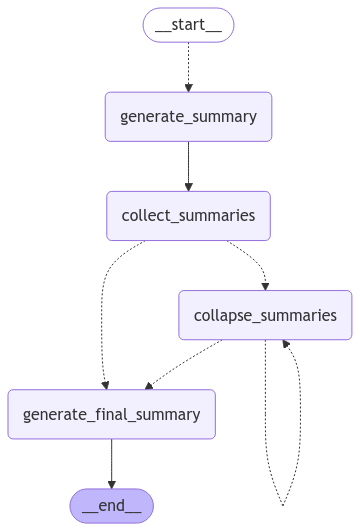

In [7]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

## Invoke graph

When running the application, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a [recursion_limit](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) on its execution. This will raise a specific error when the specified limit is exceeded.

In [15]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [16]:
print(step)

{'generate_final_summary': {'final_summary': 'The consolidated summary of the main themes from the provided documents focuses on the integration of large language models (LLMs) into autonomous agents and the structured approach to software development. Key areas highlighted include:\n\n1. **Advancements in LLM-Powered Autonomous Agents**:\n   - **Core Components**: Techniques such as Chain of Thought (CoT) and Tree of Thoughts are utilized for effective planning and task decomposition. The integration of external classical planners enhances long-term planning capabilities.\n   - **Self-Reflection and Memory Systems**: Agents employ frameworks like ReAct and Reflexion for learning from past actions, with memory categorized into sensory, short-term, and long-term types, paralleling human memory. Efficient information retrieval is supported by external storage solutions and techniques like Maximum Inner Product Search (MIPS).\n\n2. **Algorithmic Innovations**:\n   - Various approximate ne

## Next steps

Check out the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) for detail on building with LangGraph, including [this guide](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) on the details of map-reduce in LangGraph.

See the summarization [how-to guides](/docs/how_to/#summarization) for additional summarization strategies, including those designed for larger volumes of text.

See also [this tutorial](/docs/tutorials/summarization) for more detail on summarization.